# Notebook 1: Analyzing phenotypic nonlinearity across species

---

><font size="3"> This is the first of three notebooks associated with the [pub](https://research.arcadiascience.com/pub/result-nonlinear-phenotypes/) "Harnessing genotype-phenotype nonlinearity to accelerate biological prediction". The pub is concerned with 1) identifying the rate of nonlinearity among biological phenotypes (**Notebook 1**), 2) generating measures to characterize the types of nonlinearity observed among phenotypes (**Notebook 2**) and 3) creating models that incorporate nonlinear interactions to facilitate better prediction of phenotypes (**Notebook 3**).    
>    
><font size="3"> In this notebook (**Notebook 1**), we estimate the frequency of nonlinear interactions among phenotypes using empirical datasets. The species analyzed include yeast, nematodes, *Arabidopsis*, fruit flies, and mice.
>
><font size="3">All the data necessary for reproducing the pub are available via [Zenodo](https://zenodo.org/record/8298808). Accompanying code is available on [GitHub](https://github.com/Arcadia-Science/accounting-for-nonlinear-phenotypes).

---

## Initiating workspace and loading data

<font size="3"> Set working directory.

In [20]:
library(here)
here() # Should be set to the root of the repository
setwd(here())

[1] "/Users/ryanyork/Documents/Research/github/accounting-for-nonlinear-phenotypes"

<font size="3"> Source functions.

In [21]:
suppressPackageStartupMessages(source('01_code/R/nonlinear_phenotype_utils.R'))

><font size="3"> The data analyzed in this notebook are publicly available (information on their sources is outlined in the [repo](https://github.com/Arcadia-Science/accounting-for-nonlinear-phenotypes)) and have been pre-filtered/cleaned (details in the companion [pub](https://research.arcadiascience.com/pub/result-nonlinear-phenotypes/)). Each dataset represents a set of phenotypes measured from a population of genetically diverse, interbreeding individuals.
>
><font size="3"> The cleaned data are hosted on [Zenodo](https://zenodo.org/record/8298808).

---

<font size="3"> Create a directory ('data') and download data from Zenodo into that directory.

In [22]:
#Create directory to store data in
system('mkdir data')

#Download data
download_zenodo(doi = "10.5281/zenodo.8298808", 
                path = 'data/',
                quiet = TRUE)

<font size="3"> Load the data into R and compile into a single list.

In [23]:
# Yeast
yeast <- readRDS("data/yeast_cleaned_phenos.RDS")

# C. elegans
nematode <- readRDS("data/nematode_cleaned_phenos.RDS")

# Arabadopsis
ara <- readRDS("data/arapheno_cleaned_phenos.RDS")

# DGRP (fruit fly)
dgrp <- readRDS("data/dgrp_cleaned_phenos.RDS")

# JAX (mouse)
jax <- readRDS("data/jax_cleaned_phenos.RDS")

# AIL (mouse)
ail <- readRDS("data/ail_cleaned_phenos.RDS")

# Compile into a single list
phenos <- list(
  yeast,
  nematode,
  ara[[3]],
  dgrp,
  jax,
  ail
)
names(phenos) <- c("yeast", "nematode", "ara", "dgrp", "jax", "ail")

<font size="3"> Generate randomly distributed phenotypic data and add to phenotype list. 

In [24]:
# Calculate random distribution
dat <- list()
for (i in 1:20) {
  dat[[i]] <- sample(1:1000, 600, replace = TRUE)
}
dat <- do.call(cbind, dat)

# Add random data to phenotypes
phenos$random <- dat

## Calculating and comparing the frequency of phenotypic nonlinearity

><font size="3"> Now that we have downloaded and organized the data, we can begin to explore phenotypic relationships within each dataset/population. To  do so, we will use a simple test to calculate the frequency of phenotypic nonlinearity. For each dataset, we will fit both a linear and a nonlinear model for all possible phenotypic pairs. We will then compare the fit of the linear/nonlinear models using the Akaike information criterion (AIC). 
>   
><font size="3"> For each pair of phenotypes there are three possible outcomes: a tie (equal AIC), the nonlinear model is a better fit (nonlinear = lower AIC), or the linear model is a better fit (linear = lower AIC). The frequency of nonlinearity is thus calculated by comparing the ratio of the number of cases in which the nonlinear model had lower AIC compared to the full number of phenotypic comparisons. 
> 
><font size="3"> Finally, we will use permutation tests to explore the within-species variation of nonlinear frequency. Specifically, for each phenotype pair, we will randomly select 25% of the phenotypes in the dataset and compute the frequency of nonlinearity. We will do this 100 times, yielding a distribution reflecting the range of possible nonlinear frequencies. These distributions are useful in that they may help us infer the nature of observed nonlinear interactions. 
>    
><font size="3">For example, very little variation may reflect that the dataset is composed of phenotypes that are very strongly by a small number of genetic processes. On the other hand, substantial variation may suggest that multiple, modular sets of phenotypes are present (and potentially associated with simarly complex genetic processes).

---

<font size="3"> Calculate the frequency of nonlinearity using a permutation-based test. 

In [40]:
#Generate empty list to save results into
nonlinear_permutations <- list()

# Run permutation test for each species/phenotypic data set
for (i in 1:length(phenos)) {
  print(paste(i, 'out of', length(phenos)))
    
  # Given the large n for the yeast dataset, subsample data
  if (i == 1) {
    nonlinear_permutations[[names(phenos)[i]]] <- nonlinear.permutation(
        phenos[[i]][sample(1:nrow(phenos[[i]]), 1000), ],                                                      
        data_proportion = 0.25, 
        permutation_number = 100, 
        return_models = TRUE,
        counter = TRUE)

  } else {
    nonlinear_permutations[[names(phenos)[i]]] <- nonlinear.permutation(
      phenos[[i]],
      data_proportion = 0.25,
      permutation_number = 100,
      return_models = TRUE,
      counter = TRUE
    )
  }
}

# Calculate nonlinearity of random data
random <- nonlinear.permutation(
  phenos$random,
  data_proportion = 0.25,
  permutation_number = 100,
  return_models = TRUE,
  counter = TRUE
)

# Add random data to the results list
nonlinear_permutations$random <- random

[1] "1 out of 7"
  |..................................................| 100%[1] "2 out of 7"
  |..................................................| 100%[1] "3 out of 7"
  |..................................................| 100%[1] "4 out of 7"
  |..................................................| 100%[1] "5 out of 7"
  |..................................................| 100%[1] "6 out of 7"
  |..................................................| 100%[1] "7 out of 7"
  |..................................................| 100%

<font size="3"> Compare across species via Kruskal-Wallis test.

In [44]:
kruskal.test(nonlinear_permutations)


	Kruskal-Wallis rank sum test

data:  nonlinear_permutations
Kruskal-Wallis chi-squared = 566.06, df = 6, p-value < 2.2e-16


<font size="3"> Save output.

In [41]:
saveRDS(
  nonlinear_permutations,
  'data/empirical_datasets_permuted_nonlinearity.RDS'
)

><font size="3"> As described above, we are interested in both the frequency of nonlinearity and how much this measure varies across sets of phenotypes. To explore this, we will plot the frequency of nonlinearity (**first panel**; labeled "% nonlinear relationships"), its variation in the form of a mean-normalized coefficient of variation (**second panel**; "Coeff. of variation"), and the distribution of correlations among all phenotypes within each dataset (**third panel**; "Correlation")
>   

---

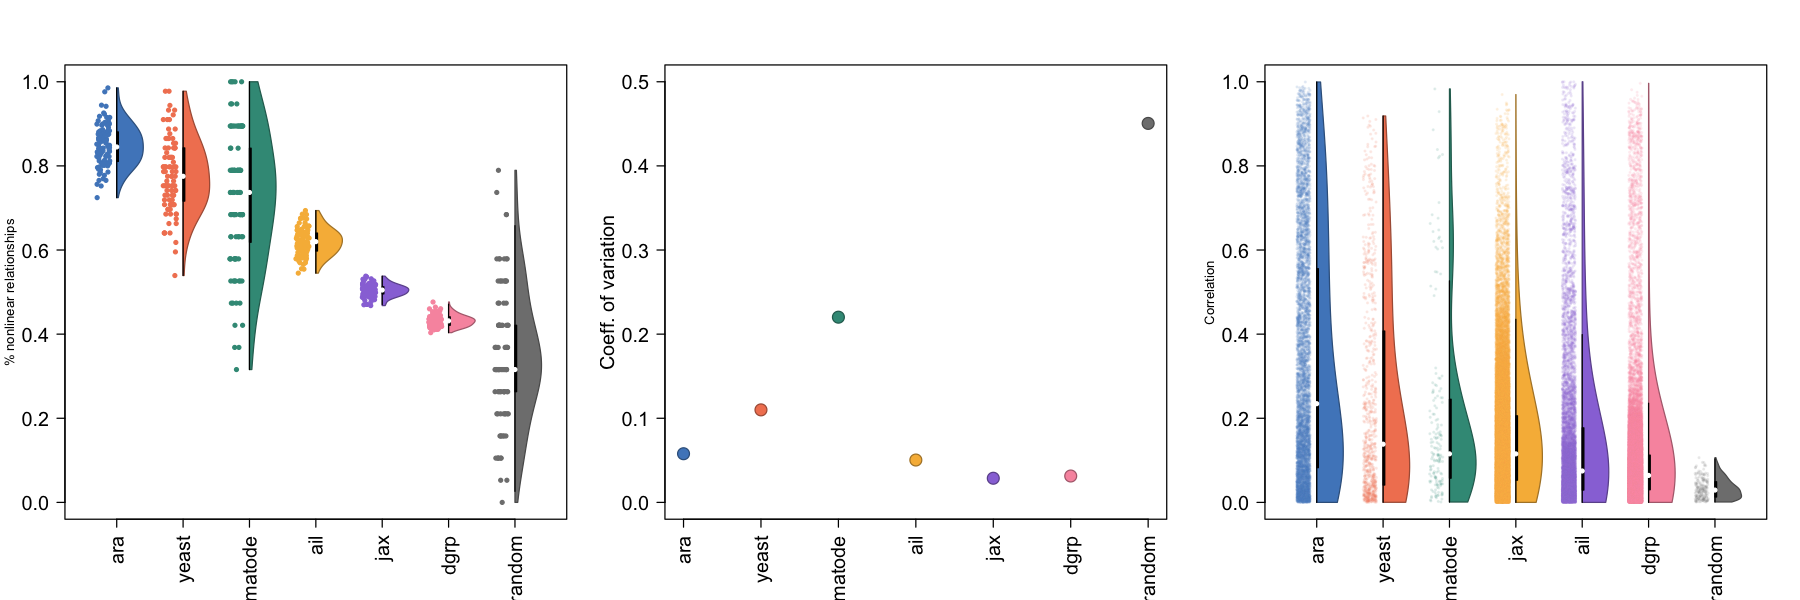

In [46]:
# Initiate plot and set size/number of panels
options(repr.plot.width = 15, repr.plot.height = 5)
par(mfrow = c(1, 3))

# Load nonlinearity results
#nonlinear_permutations <- readRDS('data/empirical_datasets_permuted_nonlinearity.RDS')

# Set colors 
cols <- c(arcadia.pal(n = 6, name = "Accent"), "gray50")
names(cols) <- names(nonlinear_permutations)

# Re-order nonlinear results
nonlinear_permutations <- nonlinear_permutations[order(unlist(lapply(nonlinear_permutations, function(x) mean(x))), decreasing = TRUE)]

# Generate half violin plots of nonlinearity frequency
vioplot::vioplot(nonlinear_permutations[[1]],
  nonlinear_permutations[[2]],
  nonlinear_permutations[[3]],
  nonlinear_permutations[[4]],
  nonlinear_permutations[[5]],
  nonlinear_permutations[[6]],
  nonlinear_permutations[[7]],
  col = cols,
  side = "right",
  border = darken_color(cols),
  ylab = "% nonlinear relationships",
  xlab = "",
  las = 2,
  names = names(nonlinear_permutations),
  cex.axis = 1.5,
  cex.lab = 1.5
)

# Add points using stripchart
stripchart(nonlinear_permutations,
  col = cols,
  at = seq(0.8, (length(nonlinear_permutations) - 1) + 0.8, 1),
  jitter = 0.1,
  method = "jitter",
  vertical = TRUE,
  cex = 1,
  pch = 20,
  add = TRUE
)

# Plot nonlinearity frequency variation
plot(unlist(lapply(nonlinear_permutations, function(x) sd(x) / mean(x))),
  pch = 21,
  ylim = c(0, 0.5),
  xlab = "",
  bg = cols,
  col = darken_color(cols),
  cex = 2,
  las = 2,
  xaxt = "n",
  ylab = "Coeff. of variation",
  cex.lab = 1.5,
  cex.axis = 1.5
)
axis(1, 1:7, labels = names(nonlinear_permutations), las = 2, cex.axis = 1.5)

# Calculate correlations among all phenotype pairs within each dataset
trait_correlations <- list()
for (i in 1:length(phenos)) {
  corr <- cor(phenos[[i]])
  trait_correlations[[names(phenos)[i]]] <- abs(unlist(as.data.frame(corr[lower.tri(corr)])))
}

# Generate half violin plots of phenotypic correlations
trait_correlations <- trait_correlations[order(unlist(lapply(trait_correlations, function(x) median(x))), 
                                                             decreasing = TRUE)]
vioplot::vioplot(trait_correlations[[1]],
  trait_correlations[[2]],
  trait_correlations[[3]],
  trait_correlations[[4]],
  trait_correlations[[5]],
  trait_correlations[[6]],
  trait_correlations[[7]],
  col = cols,
  side = "right",
  border = darken_color(cols),
  ylab = "Correlation",
  xlab = "",
  las = 2,
  names = names(trait_correlations),
  cex.axis = 1.5,
  cex.lab = 1.5
)

# Add points using stripchart
stripchart(trait_correlations,
  col = alpha(cols, 0.1),
  at = seq(0.8, (length(trait_correlations) - 1) + 0.8, 1),
  jitter = 0.1,
  method = "jitter",
  vertical = TRUE,
  cex = 0.5,
  pch = 20,
  add = TRUE
)